# 0. Install Dependencies and Bring in Data

In [ ]:
!pip install tensorflow pandas matplotlib scikit-learn

In [ ]:
!pip install datasets
from datasets import load_dataset
import pandas as pd

dataset = load_dataset("naimul011/BanglaToxicCommentsDB", data_files=["bangla_comments.csv"])

README.md: 0.00B [00:00, ?B/s]

bangla_comments.csv:   0%|          | 0.00/1.48M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'],
        num_rows: 12653
    })
})


In [ ]:

df = pd.DataFrame(dataset["train"])

In [ ]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np

In [ ]:
df = pd.read_csv(os.path.join('jigsaw-toxic-comment-classification-challenge','train.csv', 'train.csv'))

In [ ]:
df.head()

,Unnamed: 0,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0,ছবি টা দেখার পর বাড়া টা কেপে ওটলো😭😭😭,1.0,1.0,1.0,0.0,0.0,0.0
1,1,পুতুলের মতো,0.0,0.0,0.0,0.0,0.0,0.0
2,2,nicher ta dekha jacche Apu 😅😅😅😅😅,1.0,1.0,1.0,0.0,0.0,0.0
3,3,ছাগলের দল ফুল ভিডিও দেখ,1.0,0.0,0.0,0.0,0.0,0.0
4,4,পুরাই আগুন 🥰🥰🥰😌,1.0,0.0,0.0,0.0,0.0,0.0


# 1. Preprocess

In [ ]:
!pip list

Package                   Version
------------------------- -------------------------------
absl-py                   1.4.0
accelerate                1.10.0
aiofiles                  24.1.0
aiohappyeyeballs          2.6.1
aiohttp                   3.12.15
aiosignal                 1.4.0
altair                    5.5.0
annotated-types           0.7.0
anyio                     4.10.0
argon2-cffi               25.1.0
argon2-cffi-bindings      25.1.0
array_record              0.7.2
astunparse                1.6.3
attrs                     25.3.0
audioread                 3.0.1
backcall                  0.2.0
beautifulsoup4            4.13.4
betterproto               2.0.0b6
bleach                    6.2.0
blinker                   1.4
blis                      1.3.0
cachetools                5.5.2
catalogue                 2.0.10
certifi                   2025.8.3
cffi                      1.17.1
charset-normalizer        3.4.3
chex                      0.1.90
click                     8.2

In [ ]:
from tensorflow.keras.layers import TextVectorization

In [ ]:
# Drop rows with NaN values in label columns
df.dropna(subset=df.columns[2:], inplace=True)

X = df['comment_text']
y = df[df.columns[2:]].values

In [ ]:
print(X)
print(y)

0                     ছবি টা দেখার পর বাড়া টা কেপে ওটলো😭😭😭
1                                              পুতুলের মতো
2                         nicher ta dekha jacche Apu 😅😅😅😅😅
3                                  ছাগলের দল ফুল ভিডিও দেখ
4                                          পুরাই আগুন 🥰🥰🥰😌
                               ...                        
12648    পাশে💘থাকলে💘পাশে💘পাবেন।💘লাইক💘দিলে💘লাইক💘পাবেন️💘ফ...
12649                 অওঅঅঅঅঅঅ মা গ কত্ত চিকন😂😂😂😂😂😂😂😂😂😂😂😂😂
12650                                     কালো এটা কি। 🤔🤔🤔
12651         দিঘী কি সানি লিওন এর মতই নাকি কেউ বলেন জানলে
12652                                       তোর হোগায় ডিম।
Name: comment_text, Length: 12634, dtype: object
[[1. 1. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0.]
 ...
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]]


In [ ]:
MAX_FEATURES = 200000 # number of words in the vocab

In [ ]:
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_sequence_length=1800,
                               output_mode='int')

In [ ]:
vectorizer.adapt(X.values)

In [ ]:
vectorized_text = vectorizer(X.values)

In [ ]:
print(vectorized_text)

tf.Tensor(
[[  392    42   391 ...     0     0     0]
 [  898    78     0 ...     0     0     0]
 [20826    13   339 ...     0     0     0]
 ...
 [  393    16  7358 ...     0     0     0]
 [  447     3    24 ...     0     0     0]
 [   66  1733 15375 ...     0     0     0]], shape=(12634, 1800), dtype=int64)


In [ ]:
#MCSHBAP - map, chache, shuffle, batch, prefetch  from_tensor_slices, list_file
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8) # helps bottlenecks

In [ ]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

# 2. Create Sequential Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

In [ ]:
model = Sequential()
# Create the embedding layer
model.add(Embedding(MAX_FEATURES+1, 32))
# Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(32, activation='tanh')))
# Feature extractor Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
# Final layer
model.add(Dense(6, activation='sigmoid'))

In [ ]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam')

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(train, epochs=10, validation_data=val)

Epoch 1/10
553/553 ━━━━━━━━━━━━━━━━━━━━ 890s 2s/step - loss: 0.1479 - val_loss: 0.1245
Epoch 2/10
553/553 ━━━━━━━━━━━━━━━━━━━━ 905s 2s/step - loss: 0.1157 - val_loss: 0.0933
Epoch 3/10
553/553 ━━━━━━━━━━━━━━━━━━━━ 872s 2s/step - loss: 0.0956 - val_loss: 0.0833
Epoch 4/10
553/553 ━━━━━━━━━━━━━━━━━━━━ 917s 2s/step - loss: 0.0859 - val_loss: 0.0631
Epoch 5/10
553/553 ━━━━━━━━━━━━━━━━━━━━ 866s 2s/step - loss: 0.0684 - val_loss: 0.0549
Epoch 6/10
553/553 ━━━━━━━━━━━━━━━━━━━━ 886s 2s/step - loss: 0.0569 - val_loss: 0.0491
Epoch 7/10
553/553 ━━━━━━━━━━━━━━━━━━━━ 880s 2s/step - loss: 0.0495 - val_loss: 0.0373
Epoch 8/10
553/553 ━━━━━━━━━━━━━━━━━━━━ 874s 2s/step - loss: 0.0405 - val_loss: 0.0327
Epoch 9/10
553/553 ━━━━━━━━━━━━━━━━━━━━ 880s 2s/step - loss: 0.0359 - val_loss: 0.0321
Epoch 10/10
553/553 ━━━━━━━━━━━━━━━━━━━━ 865s 2s/step - loss: 0.0332 - val_loss: 0.0305


In [ ]:
# Access the history attribute and convert it to a pandas DataFrame for display
history_df = pd.DataFrame(history.history)
print(history_df)

       loss  val_loss
0  0.146831  0.124538
1  0.122264  0.093334
2  0.101040  0.083266
3  0.084602  0.063131
4  0.072271  0.054948
5  0.058320  0.049060
6  0.049817  0.037315
7  0.040431  0.032740
8  0.038250  0.032141
9  0.034728  0.030466


In [ ]:
from matplotlib import pyplot as plt

In [ ]:
print(history.history)

{'loss': [0.14683058857917786, 0.12226362526416779, 0.10103963315486908, 0.08460213243961334, 0.07227145880460739, 0.05832012742757797, 0.04981660097837448, 0.0404309518635273, 0.03824998065829277, 0.03472788631916046], 'val_loss': [0.12453830987215042, 0.09333391487598419, 0.08326571434736252, 0.06313078105449677, 0.054948147386312485, 0.04905981197953224, 0.037315115332603455, 0.032740164548158646, 0.032140739262104034, 0.03046555072069168]}


<Figure size 800x500 with 0 Axes>

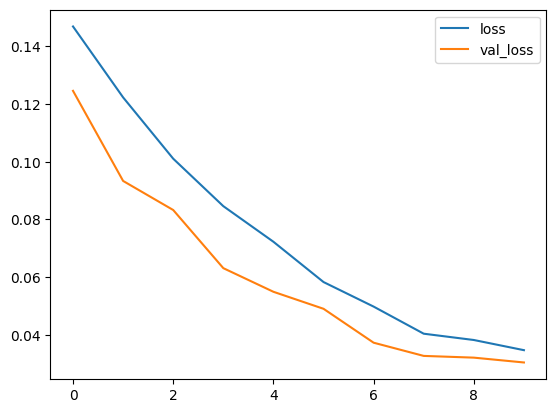

In [ ]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

Epoch 1/10
553/553 ━━━━━━━━━━━━━━━━━━━━ 643s 1s/step - loss: 0.3080 - val_loss: 0.2727
Epoch 2/10
553/553 ━━━━━━━━━━━━━━━━━━━━ 638s 1s/step - loss: 0.2700 - val_loss: 0.2516
Epoch 3/10
553/553 ━━━━━━━━━━━━━━━━━━━━ 638s 1s/step - loss: 0.2374 - val_loss: 0.1919
Epoch 4/10
553/553 ━━━━━━━━━━━━━━━━━━━━ 634s 1s/step - loss: 0.2046 - val_loss: 0.1735
Epoch 5/10
553/553 ━━━━━━━━━━━━━━━━━━━━ 633s 1s/step - loss: 0.1753 - val_loss: 0.1487
Epoch 6/10
553/553 ━━━━━━━━━━━━━━━━━━━━ 636s 1s/step - loss: 0.1429 - val_loss: 0.1162
Epoch 7/10
553/553 ━━━━━━━━━━━━━━━━━━━━ 633s 1s/step - loss: 0.1151 - val_loss: 0.0965
Epoch 8/10
553/553 ━━━━━━━━━━━━━━━━━━━━ 636s 1s/step - loss: 0.0903 - val_loss: 0.0799
Epoch 9/10
553/553 ━━━━━━━━━━━━━━━━━━━━ 636s 1s/step - loss: 0.0772 - val_loss: 0.0609
Epoch 10/10
553/553 ━━━━━━━━━━━━━━━━━━━━ 634s 1s/step - loss: 0.0636 - val_loss: 0.0578


<Figure size 800x500 with 0 Axes>

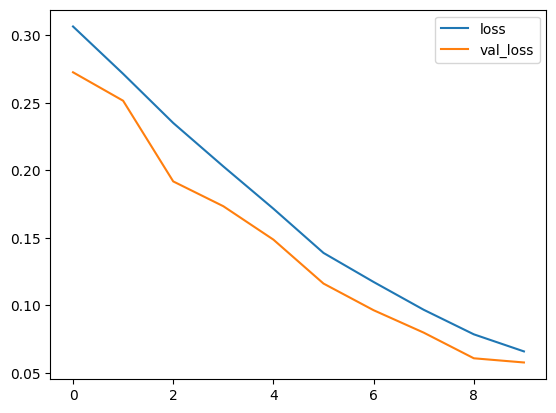

In [ ]:
history2 = model.fit(train, epochs=10, validation_data=val)
plt.figure(figsize=(8,5))
pd.DataFrame(history2.history).plot()
plt.show()

In [ ]:
print(history2.history)
model.summary()

{'loss': [0.30661502480506897, 0.27155545353889465, 0.2351563423871994, 0.20299549400806427, 0.17164841294288635, 0.1389002650976181, 0.11739300936460495, 0.09679962694644928, 0.07862386107444763, 0.06597612053155899], 'val_loss': [0.272693932056427, 0.251624196767807, 0.19187331199645996, 0.17350412905216217, 0.14874957501888275, 0.11621391028165817, 0.0964733436703682, 0.07987171411514282, 0.06087995320558548, 0.0577755942940712]}


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 1800, 32)       │     6,400,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,475,060 (74.29 MB)

 Trainable params: 6,491,686 (24.76 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 12,983,374 (49.53 MB)

In [ ]:
history3 = model.fit(train, epochs=25, validation_data=val)
print(history3.history)
model.summary()

Epoch 1/25
553/553 ━━━━━━━━━━━━━━━━━━━━ 969s 2s/step - loss: 0.4012 - val_loss: 0.3143
Epoch 2/25
553/553 ━━━━━━━━━━━━━━━━━━━━ 942s 2s/step - loss: 0.3149 - val_loss: 0.2603
Epoch 3/25
553/553 ━━━━━━━━━━━━━━━━━━━━ 938s 2s/step - loss: 0.2728 - val_loss: 0.2272
Epoch 4/25
553/553 ━━━━━━━━━━━━━━━━━━━━ 934s 2s/step - loss: 0.2295 - val_loss: 0.1794
Epoch 5/25
553/553 ━━━━━━━━━━━━━━━━━━━━ 929s 2s/step - loss: 0.1886 - val_loss: 0.1646
Epoch 6/25
553/553 ━━━━━━━━━━━━━━━━━━━━ 923s 2s/step - loss: 0.1545 - val_loss: 0.1327
Epoch 7/25
553/553 ━━━━━━━━━━━━━━━━━━━━ 985s 2s/step - loss: 0.1304 - val_loss: 0.1004
Epoch 8/25
553/553 ━━━━━━━━━━━━━━━━━━━━ 923s 2s/step - loss: 0.1047 - val_loss: 0.0843
Epoch 9/25
553/553 ━━━━━━━━━━━━━━━━━━━━ 921s 2s/step - loss: 0.0868 - val_loss: 0.0638
Epoch 10/25
553/553 ━━━━━━━━━━━━━━━━━━━━ 922s 2s/step - loss: 0.0738 - val_loss: 0.0603
Epoch 11/25
553/553 ━━━━━━━━━━━━━━━━━━━━ 919s 2s/step - loss: 0.0579 - val_loss: 0.0508
Epoch 12/25
553/553 ━━━━━━━━━━━━━━━━━━━━ 

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 1800, 32)       │     6,400,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 64)             │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,475,060 (74.29 MB)

 Trainable params: 6,491,686 (24.76 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 12,983,374 (49.53 MB)

# 3. Make Predictions

In [ ]:
input_text = vectorizer('You freaking suck! I am going to hit you.')

In [ ]:
res = model.predict(input_text)

In [ ]:
(res > 0.5).astype(int)

In [ ]:
batch_X, batch_y = test.as_numpy_iterator().next()

In [ ]:
(model.predict(batch_X) > 0.5).astype(int)

In [ ]:
res.shape

# 4. Evaluate Model

In [ ]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [ ]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [ ]:
for batch in test.as_numpy_iterator():
    # Unpack the batch
    X_true, y_true = batch
    # Make a prediction
    yhat = model.predict(X_true)

    # Flatten the predictions
    y_true = y_true.flatten()
    yhat = yhat.flatten()

    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision: 0.9736618399620056, Recall:0.9581939578056335, Accuracy:0.13924050331115723


In [ ]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

y_true_all = []
y_pred_all = []

for batch in test.as_numpy_iterator():
    X_true, y_true = batch
    yhat = model.predict(X_true)

    # Threshold predictions (multi-label problem)
    yhat = (yhat > 0.5).astype(int)

    y_true_all.append(y_true)
    y_pred_all.append(yhat)

# Concatenate everything into arrays
y_true_all = np.vstack(y_true_all)
y_pred_all = np.vstack(y_pred_all)

# 🔹 Precision & Recall
precision_macro = precision_score(y_true_all, y_pred_all, average='macro')
recall_macro = recall_score(y_true_all, y_pred_all, average='macro')

precision_micro = precision_score(y_true_all, y_pred_all, average='micro')
recall_micro = recall_score(y_true_all, y_pred_all, average='micro')

# 🔹 F1 Score
f1_macro = f1_score(y_true_all, y_pred_all, average='macro')
f1_micro = f1_score(y_true_all, y_pred_all, average='micro')

# 🔹 Accuracy
# "micro" accuracy = exact match ratio
accuracy_micro = accuracy_score(y_true_all, y_pred_all)

# "macro accuracy" isn’t built-in, but you can treat it as mean per-label accuracy
accuracy_per_label = (y_true_all == y_pred_all).mean(axis=0)
accuracy_macro = accuracy_per_label.mean()

print("---- Macro (per label averaged) ----")
print(f"Precision (Macro): {precision_macro:.4f}")
print(f"Recall (Macro):    {recall_macro:.4f}")
print(f"F1 Score (Macro):  {f1_macro:.4f}")
print(f"Accuracy (Macro):  {accuracy_macro:.4f}")

print("\n---- Micro (global averaged) ----")
print(f"Precision (Micro): {precision_micro:.4f}")
print(f"Recall (Micro):    {recall_micro:.4f}")
print(f"F1 Score (Micro):  {f1_micro:.4f}")
print(f"Accuracy (Micro):  {accuracy_micro:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

# 5. Test and Gradio

In [ ]:
!pip install gradio jinja2

In [ ]:
import tensorflow as tf
import gradio as gr

In [ ]:
model.save('toxicity.h5')

In [ ]:
model = tf.keras.models.load_model('toxicity.h5')

In [ ]:
input_str = vectorizer('hey i freaken hate you!')

In [ ]:
res = model.predict(np.expand_dims(input_str,0))

In [ ]:
res

In [ ]:
def score_comment(comment):
    vectorized_comment = vectorizer([comment])
    results = model.predict(vectorized_comment)

    text = ''
    for idx, col in enumerate(df.columns[2:]):
        text += '{}: {}\n'.format(col, results[0][idx]>0.5)

    return text

In [ ]:
interface = gr.Interface(fn=score_comment,
                         inputs=gr.inputs.Textbox(lines=2, placeholder='Comment to score'),
                        outputs='text')

In [ ]:
interface.launch(share=True)

In [ ]:
# Display descriptive statistics for numerical columns
print(df.describe())

# Check for any non-finite values in the label columns
print('\nChecking for non-finite values in label columns:')
print(df[df.columns[2:]].isnull().sum())
print(df[df.columns[2:]].apply(lambda x: np.isinf(x).sum()))

         Unnamed: 0         toxic  severe_toxic       obscene        threat  \
count  12653.000000  12648.000000  12653.000000  12648.000000  12648.000000   
mean    6326.000000      0.377451      0.125188      0.132906      0.033365   
std     3652.750813      0.484768      0.330945      0.339487      0.179595   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%     3163.000000      0.000000      0.000000      0.000000      0.000000   
50%     6326.000000      0.000000      0.000000      0.000000      0.000000   
75%     9489.000000      1.000000      0.000000      0.000000      0.000000   
max    12652.000000      1.000000      1.000000      1.000000      1.000000   

             insult  identity_hate  
count  12650.000000   12652.000000  
mean       0.205138       0.057540  
std        0.403819       0.232881  
min        0.000000       0.000000  
25%        0.000000       0.000000  
50%        0.000000       0.000000  
75%        0.000000       0.0

In [ ]:
history = model.fit(train, epochs=15, validation_data=val)

Epoch 1/15
553/553 ━━━━━━━━━━━━━━━━━━━━ 907s 2s/step - loss: 0.0305 - val_loss: 0.0203
Epoch 2/15
553/553 ━━━━━━━━━━━━━━━━━━━━ 898s 2s/step - loss: 0.0263 - val_loss: 0.0257
Epoch 3/15
553/553 ━━━━━━━━━━━━━━━━━━━━ 890s 2s/step - loss: 0.0233 - val_loss: 0.0207
Epoch 4/15
553/553 ━━━━━━━━━━━━━━━━━━━━ 925s 2s/step - loss: 0.0212 - val_loss: 0.0207
Epoch 5/15
553/553 ━━━━━━━━━━━━━━━━━━━━ 893s 2s/step - loss: 0.0196 - val_loss: 0.0167
Epoch 6/15
553/553 ━━━━━━━━━━━━━━━━━━━━ 859s 2s/step - loss: 0.0160 - val_loss: 0.0130
Epoch 7/15
553/553 ━━━━━━━━━━━━━━━━━━━━ 859s 2s/step - loss: 0.0189 - val_loss: 0.0140
Epoch 8/15
553/553 ━━━━━━━━━━━━━━━━━━━━ 860s 2s/step - loss: 0.0158 - val_loss: 0.0143
Epoch 9/15
 75/553 ━━━━━━━━━━━━━━━━━━━━ 11:57 2s/step - loss: 0.0140

In [ ]:
model.summary()

In [ ]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

y_true_all = []
y_pred_all = []

for batch in test.as_numpy_iterator():
    X_true, y_true = batch
    yhat = model.predict(X_true)

    # Threshold predictions (multi-label problem)
    yhat = (yhat > 0.5).astype(int)

    y_true_all.append(y_true)
    y_pred_all.append(yhat)

# Concatenate everything into arrays
y_true_all = np.vstack(y_true_all)
y_pred_all = np.vstack(y_pred_all)

# 🔹 Precision & Recall
precision_macro = precision_score(y_true_all, y_pred_all, average='macro')
recall_macro = recall_score(y_true_all, y_pred_all, average='macro')

precision_micro = precision_score(y_true_all, y_pred_all, average='micro')
recall_micro = recall_score(y_true_all, y_pred_all, average='micro')

# 🔹 F1 Score
f1_macro = f1_score(y_true_all, y_pred_all, average='macro')
f1_micro = f1_score(y_true_all, y_pred_all, average='micro')

# 🔹 Accuracy
# "micro" accuracy = exact match ratio
accuracy_micro = accuracy_score(y_true_all, y_pred_all)

# "macro accuracy" isn’t built-in, but you can treat it as mean per-label accuracy
accuracy_per_label = (y_true_all == y_pred_all).mean(axis=0)
accuracy_macro = accuracy_per_label.mean()

print("---- Macro (per label averaged) ----")
print(f"Precision (Macro): {precision_macro:.4f}")
print(f"Recall (Macro):    {recall_macro:.4f}")
print(f"F1 Score (Macro):  {f1_macro:.4f}")
print(f"Accuracy (Macro):  {accuracy_macro:.4f}")

print("\n---- Micro (global averaged) ----")
print(f"Precision (Micro): {precision_micro:.4f}")
print(f"Recall (Micro):    {recall_micro:.4f}")
print(f"F1 Score (Micro):  {f1_micro:.4f}")
print(f"Accuracy (Micro):  {accuracy_micro:.4f}")


## 6. Evaluation

In [ ]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

y_true_all = []
y_pred_all = []

for batch in test.as_numpy_iterator():
    X_true, y_true = batch
    yhat = model.predict(X_true)

    # Threshold predictions (multi-label problem)
    yhat = (yhat > 0.5).astype(int)

    y_true_all.append(y_true)
    y_pred_all.append(yhat)

# Concatenate everything into arrays
y_true_all = np.vstack(y_true_all)
y_pred_all = np.vstack(y_pred_all)

# 🔹 Precision & Recall
precision_macro = precision_score(y_true_all, y_pred_all, average='macro')
recall_macro = recall_score(y_true_all, y_pred_all, average='macro')

precision_micro = precision_score(y_true_all, y_pred_all, average='micro')
recall_micro = recall_score(y_true_all, y_pred_all, average='micro')

# 🔹 F1 Score
f1_macro = f1_score(y_true_all, y_pred_all, average='macro')
f1_micro = f1_score(y_true_all, y_pred_all, average='micro')

# 🔹 Accuracy
# "micro" accuracy = exact match ratio
accuracy_micro = accuracy_score(y_true_all, y_pred_all)

# "macro accuracy" isn’t built-in, but you can treat it as mean per-label accuracy
accuracy_per_label = (y_true_all == y_pred_all).mean(axis=0)
accuracy_macro = accuracy_per_label.mean()

print("---- Macro (per label averaged) ----")
print(f"Precision (Macro): {precision_macro:.4f}")
print(f"Recall (Macro):    {recall_macro:.4f}")
print(f"F1 Score (Macro):  {f1_macro:.4f}")
print(f"Accuracy (Macro):  {accuracy_macro:.4f}")

print("\n---- Micro (global averaged) ----")
print(f"Precision (Micro): {precision_micro:.4f}")
print(f"Recall (Micro):    {recall_micro:.4f}")
print(f"F1 Score (Micro):  {f1_micro:.4f}")
print(f"Accuracy (Micro):  {accuracy_micro:.4f}")

In [ ]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

y_true_all = []
y_pred_all = []

for batch in test.as_numpy_iterator():
    X_true, y_true = batch
    yhat = model.predict(X_true)

    # Threshold predictions (multi-label problem)
    yhat = (yhat > 0.5).astype(int)

    y_true_all.append(y_true)
    y_pred_all.append(yhat)

# Concatenate everything into arrays
y_true_all = np.vstack(y_true_all)
y_pred_all = np.vstack(y_pred_all)

# 🔹 Precision & Recall
precision_macro = precision_score(y_true_all, y_pred_all, average='macro')
recall_macro = recall_score(y_true_all, y_pred_all, average='macro')

precision_micro = precision_score(y_true_all, y_pred_all, average='micro')
recall_micro = recall_score(y_true_all, y_pred_all, average='micro')

# 🔹 F1 Score
f1_macro = f1_score(y_true_all, y_pred_all, average='macro')
f1_micro = f1_score(y_true_all, y_pred_all, average='micro')

# 🔹 Accuracy
# "micro" accuracy = exact match ratio
accuracy_micro = accuracy_score(y_true_all, y_pred_all)

# "macro accuracy" isn’t built-in, but you can treat it as mean per-label accuracy
accuracy_per_label = (y_true_all == y_pred_all).mean(axis=0)
accuracy_macro = accuracy_per_label.mean()

print("---- Macro (per label averaged) ----")
print(f"Precision (Macro): {precision_macro:.4f}")
print(f"Recall (Macro):    {recall_macro:.4f}")
print(f"F1 Score (Macro):  {f1_macro:.4f}")
print(f"Accuracy (Macro):  {accuracy_macro:.4f}")

print("\n---- Micro (global averaged) ----")
print(f"Precision (Micro): {precision_micro:.4f}")
print(f"Recall (Micro):    {recall_micro:.4f}")
print(f"F1 Score (Micro):  {f1_micro:.4f}")
print(f"Accuracy (Micro):  {accuracy_micro:.4f}")